In [86]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import numpy.linalg as la
from matplotlib import gridspec
    
    
def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples
import toric.shims

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def drawSetup(fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    pylab.rcParams['figure.figsize'] = 8, 8

    plt.axes().set_aspect('equal')
    fig = plt.gcf()
    
    # Set up plot size
    plt.axes().set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    plt.axes().set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    plt.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)
    line_AB = plt.Line2D([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()], c="black",alpha=0.3)
    fig.gca().add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)
    
    fig.gca().add_artist(circle_PA_1)
    fig.gca().add_artist(circle_PB_1)

    plt.annotate(s="A", xy=(PA_1.x(),PA_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="B", xy=(PB_1.x(),PB_1.y()),xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    plt.scatter([C_0.x(), C_1.x()],[C_0.y(), C_1.y()],c="blue",linewidths=0)
    plt.annotate(s="C0", xy=(C_0.x(), C_0.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="C1", xy=(C_1.x(), C_1.y()),xytext=(3,4),textcoords="offset points")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# An alternative to averaging trajectories: The trajectory blending function $w_i(\vec{\sigma}_A,\vec{\sigma}_B,u)$

Recall from the notebook *"NJ - 06 - Toric Interpolation Proof of Min Dist Constraint Maintenance"*

We are attempting to find $\vec{\sigma}(u)$ that respects the following constraints:


$$
\begin{align}
\|\vec{\sigma}(u) - \vec{A}\| && \geq && d_m \\
\|\vec{\sigma}(u) - \vec{B}\| && \geq && d_m
\end{align}
$$

<span style="color: green"> 
**NOTE TO SELF:** If you start easing the change in screen position, you can either ease your movement along this trajectory... Or you can find a *different* trajectory that has the same visual easing behavior but with a potentially shorter camera path. To do this we need a joint optimization approach.
</span>

We also have these nice *spherical interpolation* functions. Moving along this trajectory will linearly change the size of people on screen.

$$
\begin{align}
\vec{\sigma}_A(u) & = \vec{A} + d_A(u)\vec{v}_A(u) \\
\vec{\sigma}_B(u) & = \vec{B} + d_B(u)\vec{v}_B(u) \\
\end{align}
$$


Notice that $\vec{\sigma}_A(u)$ respects the minimum distance bounds on A, and $\vec{\sigma}_B(u)$ respects the minimum distance bounds on B. Thus, we are only concerned with $\vec{\sigma}_A(u)$ coming close to B and vice versa.

Let's suggest a different way to combine these two trajectories.



Here's how we calculate the full trajectory $\vec{\sigma}(u)$:


$$
\vec{\sigma}(u) = w_A(\vec{\sigma}_A,\vec{\sigma}_B,u)\cdot\vec{\sigma}_A(u) \;\, + \;\, w_B(\vec{\sigma}_B,\vec{\sigma}_B,u)\cdot\vec{\sigma}_B(u)
$$

What is $w_A$?

* We want a function that, if both $\vec{\sigma}_A(u)$ and $\vec{\sigma}_B(u)$ are far away from A and B, just averages the two. If $\vec{\sigma}_A(u)$ gets close to B, it picks only $\vec{\sigma}_B(u)$, and vice versa.
* This function needs to guarantee C4-or-better continuity to generate quadrotor feasible paths.
* We want to algebraically formulate this function so its easy to evaluate, ideally.

<span style="color: green"> 
**NOTE TO SELF:** This assumes we want to pick ONLY B if A is bad, or pick ONLY A if B is bad. That might not be the right thing - we can prefer to weight A only *slightly* more, must enough to avoid the minimum distance sphere... but that's harder.
</span>


Let's formulate this function and its behavior explicitly. We call it $w_i(\vec{\sigma}_A,\vec{\sigma}_B;u)$

$$
w_A(\vec{\sigma}_A,\vec{\sigma}_B;u)= 
\begin{cases}
    1,& \text{if }  \|\vec{\sigma}_B(u) - A\| \leq d_{min}\\
    0,& \text{if }  \|\vec{\sigma}_A(u) - B\| \leq d_{min}\\
    0.5,              & \text{otherwise}
\end{cases}
$$

Which we generalize to

$$
w_i(\vec{\sigma}_i,\vec{\sigma}_{j};u)= 
\begin{cases}
    1,& \text{if }  \|\vec{\sigma}_j(u) - i\| \leq d_{min}\\
    0,& \text{if }  \|\vec{\sigma}_i(u) - j\| \leq d_{min}\\
    0.5,              & \text{otherwise}
\end{cases}
$$

Notice this function is **symmetric!**, that is $w_B = (1 - w_A)$

The weights also need to satisfy an additional property to ensure the resulting $\vec{\sigma}$ is within the convex hull of $\vec{\sigma}_A$ and $\vec{\sigma}_B$

$$
\sum_i w_i = 1
$$


** Restriction: We still consider the case where $\vec{C}_0$ and $\vec{C}_1$ are both on the same side of the line $AB$.** We might be able to relax this restriction, but lets keep it in place for the moment

## Let's implement that if-statement directly. Notice it violates C4, but thats okay.

Notice that, if we do that directly, we won't have ANY continuity, not even in position. Let's confirm.


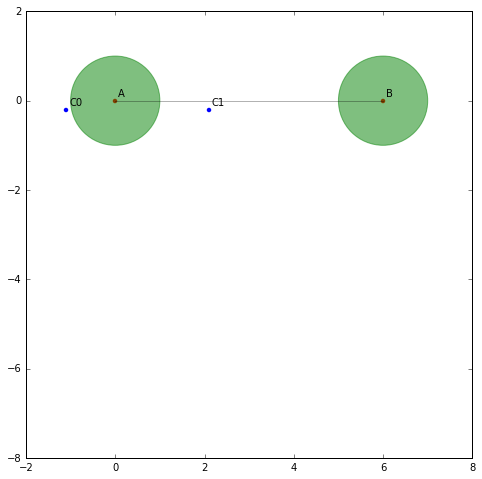

In [63]:
min_dist = 1                    # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-1.1,-0.2,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 2.1,-0.2,0)    # Ending camera position
drawSetup()

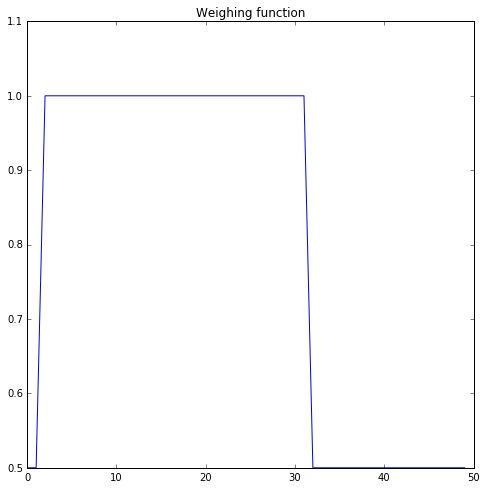

In [64]:
# Create Numpy arrays
A = PA_1.np()
B = PB_1.np()
C0 = C_0.np()
C1 = C_1.np()

# Set up interpolation vector
u = np.c_[np.linspace(0,1)]

# Set up the distance components of sigmaA, sigmaB
dA0 = la.norm(C0 - A)
dA1 = la.norm(C1 - A)
dB0 = la.norm(C0 - B)
dB1 = la.norm(C1 - B)

dA = np.linspace(dA0, dA1)
dB = np.linspace(dB0, dB1)

# Set up the vantage vector components of sigmaA, sigmaB
vA0 = (C0 - A) / dA0
vA1 = (C1 - A) / dA1
vB0 = (C0 - B) / dB0
vB1 = (C1 - B) / dB1

vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

# Set up sigmaA, sigmaB, sigma
sigmaA = A + dA[:,np.newaxis] * vA
sigmaB = B + dB[:,np.newaxis] * vB


def calc_weight(sigma_i, sigma_j, i, j):
    def silly_map(sigmas):
        sigmaiu = sigmas[0:3]
        sigmaju = sigmas[3:6]
        if la.norm(sigmaju - i) < min_dist:
            return 1
        elif la.norm(sigmaiu - j) < min_dist:
            return 0
        else:
            return 0.5
    
    return np.apply_along_axis(silly_map, axis=1, arr=np.c_[sigma_i, sigma_j]) 

wA = calc_weight(sigmaA, sigmaB, A, B)

sigmaWeighted = (wA[:,np.newaxis]*sigmaA + (1 - wA)[:,np.newaxis]*sigmaB)
sigmaAvg = (sigmaA + sigmaB)/2

plt.plot(wA)
plt.title("Weighing function")

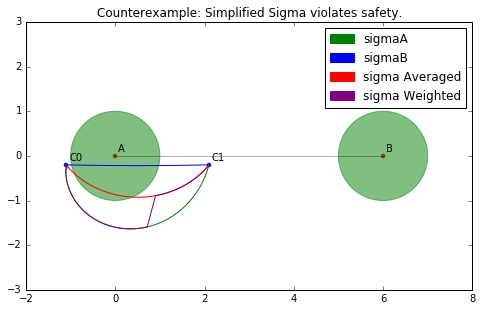

In [65]:
drawSetup(fudgeY_neg=3,fudgeY_pos=3)
plt.plot(sigmaA[:,0],sigmaA[:,1], c="green")
plt.plot(sigmaB[:,0],sigmaB[:,1], c="blue")
plt.plot(sigmaAvg[:,0], sigmaAvg[:,1],  c="red")
plt.plot(sigmaWeighted[:,0], sigmaWeighted[:,1],  c="purple")

plt.title("Counterexample: Simplified Sigma violates safety.")

sA_legend = mpatches.Patch(color="green", label="sigmaA")
sB_legend = mpatches.Patch(color="blue", label="sigmaB")
SA_legend  = mpatches.Patch(color="red", label="sigma Averaged")
SW_legend  = mpatches.Patch(color="purple", label="sigma Weighted")

plt.legend(handles=[sA_legend,sB_legend,SA_legend,SW_legend])

## Let's extend that if-statement to sigmoids so they are C4 continuous... and changes it to a soft constraint.


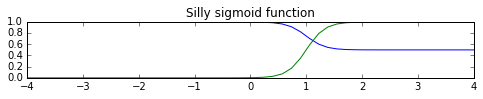

In [66]:
from scipy.special import expit

x = np.linspace(-4,4)
off = 1
sc = 6
y1 = expit(-sc*(x-off))/2 + 0.5


y2 = expit(sc*(x-off))

plt.plot(x,y1)
plt.plot(x,y2)

plt.axes().set_aspect('equal')
plt.title("Silly sigmoid function")

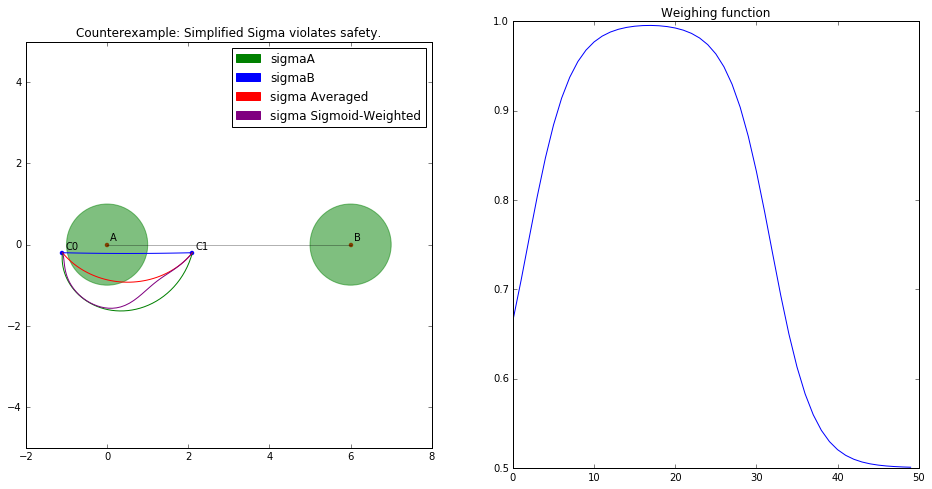

In [189]:
from scipy.special import expit

def drawSetup(subfig, PA, PB, C0, C1, mindist, fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):

    subfig.set_aspect('equal')
    fig = subfig
    
    # Set up plot size
    subfig.set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    subfig.set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    subfig.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)
    line_AB = plt.Line2D([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()], c="black",alpha=0.3)
    subfig.add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)
    
    subfig.add_artist(circle_PA_1)
    subfig.add_artist(circle_PB_1)

    subfig.annotate(s="A", xy=(PA_1.x(),PA_1.y()),xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="B", xy=(PB_1.x(),PB_1.y()),xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    subfig.scatter([C_0.x(), C_1.x()],[C_0.y(), C_1.y()],c="blue",linewidths=0)
    subfig.annotate(s="C0", xy=(C_0.x(), C_0.y()),xytext=(3,4),textcoords="offset points")
    subfig.annotate(s="C1", xy=(C_1.x(), C_1.y()),xytext=(3,4),textcoords="offset points")


def sigmoid_blended_trajectory(PA, PB, C0, C1, min_dist, sig_scale=6):
    # Create Numpy arrays
    A = PA.np()
    B = PB.np()
    C0 = C0.np()
    C1 = C1.np()

    # Set up interpolation vector
    u = np.c_[np.linspace(0,1)]

    # Set up the distance components of sigmaA, sigmaB
    dA0 = la.norm(C0 - A)
    dA1 = la.norm(C1 - A)
    dB0 = la.norm(C0 - B)
    dB1 = la.norm(C1 - B)

    dA = np.linspace(dA0, dA1)
    dB = np.linspace(dB0, dB1)

    # Set up the vantage vector components of sigmaA, sigmaB
    vA0 = (C0 - A) / dA0
    vA1 = (C1 - A) / dA1
    vB0 = (C0 - B) / dB0
    vB1 = (C1 - B) / dB1

    vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
    vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

    # Set up sigmaA, sigmaB, sigma
    sigmaA = A + dA[:,np.newaxis] * vA
    sigmaB = B + dB[:,np.newaxis] * vB

    def calc_weight(sigma_i, sigma_j, i, j):
        scale = sig_scale

        def silly_map(sigmas):
            sigmaiu = sigmas[0:3]
            sigmaju = sigmas[3:6]

            w1 = expit(-scale*(la.norm(sigmaju - i) - min_dist))/2 + 0.5 #weight one goes from 1 to 0.5
            w2 = expit(scale*(la.norm(sigmaiu - j) - min_dist))
            return w1*w2

        return np.apply_along_axis(silly_map, axis=1, arr=np.c_[sigma_i, sigma_j]) 

    wA = calc_weight(sigmaA, sigmaB, A, B)

    sigmaWeighted = (wA[:,np.newaxis]*sigmaA + (1-wA)[:,np.newaxis]*sigmaB)
    sigmaAvg = (sigmaA + sigmaB)/2
    
    
    pylab.rcParams['figure.figsize'] = 16, 8
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1], height_ratios=[1]) 
    fig = plt.figure()
    f1 = fig.add_subplot(gs[0])
    f2 = fig.add_subplot(gs[1])

    drawSetup(f1, PA, PB, C0, C1, min_dist,fudgeY_neg=(4+min_dist),fudgeY_pos=(4+min_dist),fudgeX=1+min_dist)
    f1.plot(sigmaA[:,0],sigmaA[:,1], c="green")
    f1.plot(sigmaB[:,0],sigmaB[:,1], c="blue")
    f1.plot(sigmaAvg[:,0], sigmaAvg[:,1],  c="red")
    f1.plot(sigmaWeighted[:,0], sigmaWeighted[:,1],  c="purple")

    f1.set_title("Counterexample: Simplified Sigma violates safety.")

    sA_legend = mpatches.Patch(color="green", label="sigmaA")
    sB_legend = mpatches.Patch(color="blue", label="sigmaB")
    SA_legend  = mpatches.Patch(color="red", label="sigma Averaged")
    SW_legend  = mpatches.Patch(color="purple", label="sigma Sigmoid-Weighted")

    f1.legend(handles=[sA_legend,sB_legend,SA_legend,SW_legend])
    
    
    f2.plot(wA)
    f2.set_title("Weighing function")

min_dist = 1                    # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-1.1,-0.2,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 2.1,-0.2,0)    # Ending camera position
sigmoid_blended_trajectory(PA_1, PB_1, C_0, C_1, min_dist, sig_scale=6)

### How bad is the "soft constraint"?

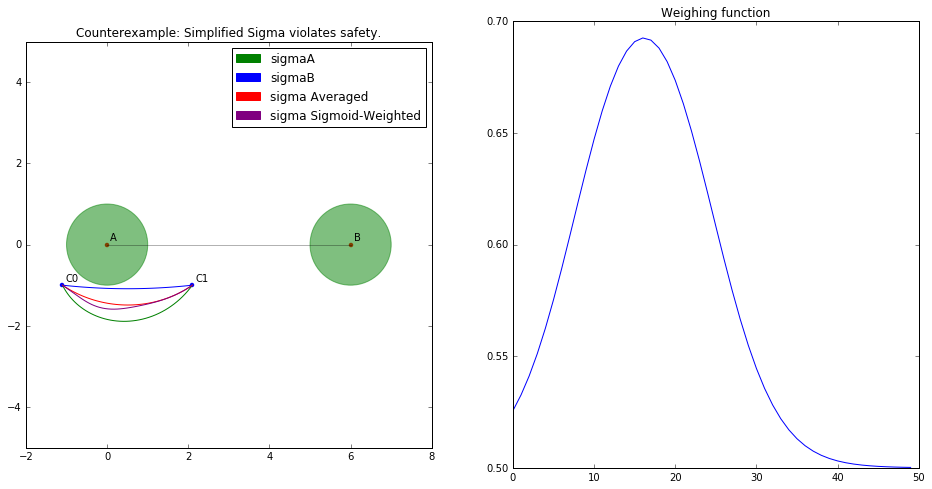

In [190]:
min_dist = 1                   # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-1.1,-1,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 2.1,-1,0)    # Ending camera position
sigmoid_blended_trajectory(PA_1, PB_1, C_0, C_1, min_dist, sig_scale=6)

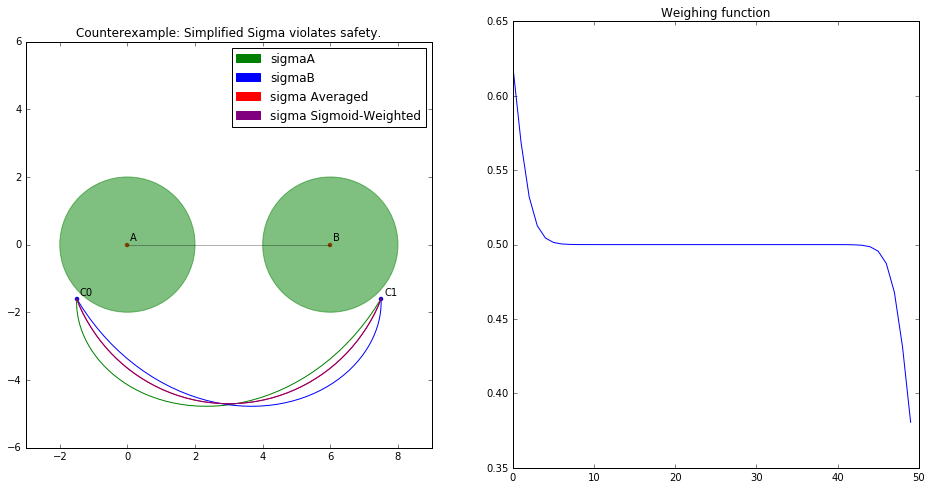

In [191]:
min_dist = 2                   # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-1.5,-1.6,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 7.5,-1.6,0)    # Ending camera position
sigmoid_blended_trajectory(PA_1, PB_1, C_0, C_1, min_dist, sig_scale=6)

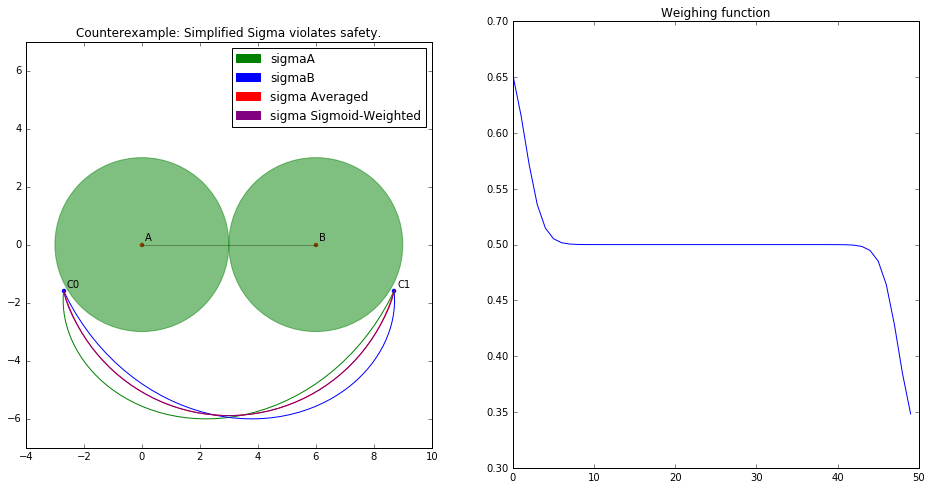

In [192]:
min_dist = 3                   # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-2.7,-1.6,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 8.7,-1.6,0)    # Ending camera position
sigmoid_blended_trajectory(PA_1, PB_1, C_0, C_1, min_dist, sig_scale=6)

**What, exactly is this saying? It's saying "If we cannot make B linearly bigger because of a minimum distance constraint, choose to let only A become linearly bigger! FORGET B completely!"**

- *That might be okay!*
